In [82]:
pip install icecream

In [83]:
pip install tensorflow-gan

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers.legacy import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.layers import ReLU
from keras.layers import Add
import pandas as pd
import os
from icecream import ic
import numpy as np
import cv2
import tensorflow_gan as tfgan
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3

In [88]:
dataset_birds = False
dataset_celebs = True
dataset_birds_10_classes = False
dataset_birds_10_classes_augm = False
if dataset_birds:
  n_classes = 200
elif dataset_celebs:
  n_classes = 8
else:
  n_classes = 10

In [89]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64, 64, 3), n_classes=None):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample to 32x32x64
    fe = Conv2D(64, (5,5), strides=(2,2), padding='same')(merge)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 16x16x128
    fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 8x8x128
    fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_discriminator_256(in_shape=(256, 256, 3), n_classes=None):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    df_dim = 64
    # downsample to 128x128xdf_dim
    fe = Conv2D(df_dim, (4,4), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 64x64xdf_dim*2
    fe = Conv2D(df_dim*2, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 32x32xdf_dim*4
    fe = Conv2D(df_dim*4, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 16x16xdf_dim*8
    fe = Conv2D(df_dim*8, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 8x8xdf_dim*16
    fe = Conv2D(df_dim*16, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 4x4xdf_dim*32
    fe = Conv2D(df_dim*32, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 4x4xdf_dim*16
    fe = Conv2D(df_dim*16, (1,1), strides=(1,1), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 4x4xdf_dim*8
    fe = Conv2D(df_dim*5, (1,1), strides=(1,1), padding='same')(fe)
    fe = BatchNormalization()(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [90]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=None):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 8 * 8
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((8, 8, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 8 * 8 * 512
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 512))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to  16x16x256 (14x14)
    gen = Conv2DTranspose(256, (5,5), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to  32x32x128 (14x14)
    gen = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 64x64x64 (28x28)
    gen = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output 64x64x3
    out_layer = Conv2D(3, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

def residual_block(in_vec):
    gf_dim = 128
    # Store input vector for later addition
    identity = in_vec   # 16x16xgf_dim*4
    # Resample to 16x16xgf_dim*4
    fe = Conv2D(gf_dim*4, (3,3), strides=(1,1), padding='same')(in_vec)
    fe = BatchNormalization()(fe)
    fe = ReLU()(fe)
    # Resample to 16x16xgf_dim*4
    fe = Conv2D(gf_dim*4, (3,3), strides=(1,1), padding='same')(fe)
    fe = BatchNormalization()(fe)

    # Add input vector
    output = Add()([identity, fe])
    output = ReLU()(output)

    return output

# define the standalone generator model
def define_generator_256(in_shape=(64, 64, 3), n_classes=None):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 16 * 16 * 128
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((16, 16, 128))(li)

    # image input encoding
    in_image = Input(shape=in_shape)
    gf_dim = 128
    # downsample to 64x64xgf_dim
    fe = Conv2D(gf_dim, (3,3), strides=(1,1), padding='same')(in_image)
    fe = ReLU()(fe)
    # downsample to 32x32xgf_dim*2
    fe = Conv2D(gf_dim*2, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = ReLU()(fe)
    # downsample to 16x16xgf_dim*4
    fe = Conv2D(gf_dim*4, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = ReLU()(fe)

    # Merge image and class embedings
    merge = Concatenate()([fe, li])     # 16x16x(128+gf_dim*4)
    # downsample to 16x16xgf_dim*4
    merge = Conv2D(gf_dim*4, (3,3), strides=(1,1), padding='same')(merge)
    merge = BatchNormalization()(merge)
    merge = ReLU()(merge)

    # Residual blocks
    rb = residual_block(merge)
    rb = residual_block(rb)
    rb = residual_block(rb)
    rb = residual_block(rb)     # 16x16xgf_dim*4

    # Generator
    # upsample to  32x32xgf_dim*2
    gen = Conv2DTranspose(gf_dim*2, (5,5), strides=(2,2), padding='same')(rb)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)
    # upsample to  64x64xgf_dim
    gen = Conv2DTranspose(gf_dim, (5,5), strides=(2,2), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)
    # upsample to  128x128xgf_dim//2
    gen = Conv2DTranspose(gf_dim//2, (5,5), strides=(2,2), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)
    # upsample to  256x256xgf_dim//4
    gen = Conv2DTranspose(gf_dim//4, (5,5), strides=(2,2), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)

    # output 256x256x3
    out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_image, in_label], out_layer)
    return model

In [91]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan_256(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_img, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_img, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [92]:
def process_images(dataframe, target_size=(100, 100)):
    processed_images = []

    for _, row in dataframe.iterrows():
        current_path = os.getcwd()
        #img_path = os.path.join(current_path, 'CUB_200_2011', 'CUB_200_2011', 'images', row['filepath'])
        current_path = '/content/drive/MyDrive/ksy'
        img_path = os.path.join(current_path, 'CUB_200_2011', 'images', row['filepath'])
        if not os.path.exists(img_path):
            continue  # skip if file does not exist

        # Read the image
        img = cv2.imread(img_path)

        # Crop the image
        x, y, w, h = row['box_x'], row['box_y'], row['box_w'], row['box_h']
        crop_img = img[int(y):int(y+h), int(x):int(x+w)]

        # Resize the image
        resized_img = cv2.resize(crop_img, target_size)

        # Append to the list
        processed_images.append(resized_img)

    return np.array(processed_images)

# load CUB dataset images
def load_real_birds():
    # load images
    current_path = os.getcwd()
    ic(current_path)
    # ic(os.path.join(current_path, 'CUB_200_2011', 'CUB_200_2011', 'images.txt'))
    current_path = '/content/drive/MyDrive/ksy'
    images = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'images.txt'), sep=' ',
                            names=['img_id', 'filepath'])
    # ic(images.shape)
    image_class_labels = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'image_class_labels.txt'),
                                        sep=' ', names=['img_id', 'target'])
    train_test_split = pd.read_csv(os.path.join(current_path,  'CUB_200_2011', 'train_test_split.txt'),
                                    sep=' ', names=['img_id', 'is_training_img'])
    bounding_boxes = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'bounding_boxes.txt'),
                                    sep=' ', names=['img_id', 'box_x', 'box_y', 'box_w', 'box_h'])
    parts_locs = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'parts', 'part_locs.txt'),
                                    sep=' ', names=['img_id', 'part_id', 'part_x', 'part_y', 'visible'])
    ic(parts_locs.shape)
    # atributes = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'CUB_200_2011', 'attributes', 'image_attribute_labels.txt'),
    #                                 sep=' ', names=['img_id', 'attribute_id', 'is_present', 'certainty_id', 'time'])
    data = images.merge(image_class_labels, on='img_id')
    data = data.merge(train_test_split, on='img_id')
    data = data.merge(bounding_boxes, on='img_id')
    # data = data.merge(parts_locs, on='img_id')

    ic(data.shape)
    # ic(data.head())

    image_data = process_images(data).astype('float32')
    image_data = (image_data - 127.5) / 127.5
    ic(image_data.shape)
    # ic(image_data.min(), image_data.max())
    labels = data.values[:, 2].reshape((-1, 1)).astype('float32')
    ic(labels.shape)

    # if train:
    #     data = data[data.is_training_img == 1]
    # else:
    #     data = data[data.is_training_img == 0]

    return [image_data, labels], parts_locs

# dataset, parts = load_real_birds()


In [93]:
if dataset_birds:
  img_data = np.load("/content/drive/MyDrive/ksy/image_data.npy")
  labels = np.load("/content/drive/MyDrive/ksy/labels.npy")
  parts = np.load("/content/drive/MyDrive/ksy/parts.npy")
elif dataset_celebs:
  img_data = np.load("/content/drive/MyDrive/ksy/image_data_c.npy")
  labels = np.load("/content/drive/MyDrive/ksy/labels_c.npy")
elif dataset_birds_10_classes:
  img_data = np.load("/content/drive/MyDrive/ksy/image_data_birds_10_classes.npy")
  labels = np.load("/content/drive/MyDrive/ksy/labels_birds_10_classes.npy")
elif dataset_birds_10_classes_augm:
  img_data = np.load("/content/drive/MyDrive/ksy/image_data_birds_10_classes_augm.npy")
  labels = np.load("/content/drive/MyDrive/ksy/labels_birds_10_classes_augm.npy")
dataset = [img_data, labels]

ic| dataset[0].min(): -1.0, dataset[0].max(): 1.0
ic| dataset[0].shape: (14715, 64, 64, 3), dataset[1].shape: (14715,)


((14715, 64, 64, 3), (14715,))

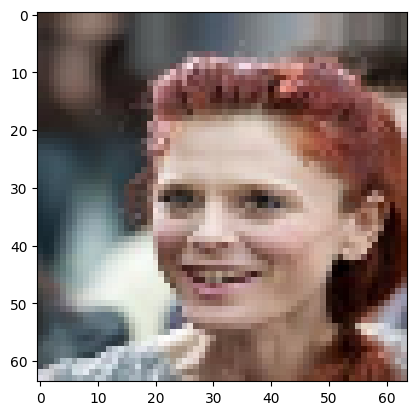

In [94]:
import matplotlib.pyplot as plt
plt.imshow((dataset[0][1] + 1)/2)
ic(dataset[0].min(), dataset[0].max())
ic(dataset[0].shape, dataset[1].shape)

In [95]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

[X_real, labels_real], y_real = generate_real_samples(dataset, 64)

In [96]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=8):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # ic(x_input)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# [z_input, labels_input] = generate_latent_points(100, 64)
# ic(z_input.shape, z_input)
# ic(labels_input.shape, labels_input)


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples, n_classes=None):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples, n_classes)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples_256(generator, generator_256, latent_dim, n_samples, n_classes=None):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples, n_classes)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # predict outputs of size 256
    images = generator_256.predict([images, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [97]:
def get_fid_score(real_image, gen_image):
    inc_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE

    resized_real_images = tf.image.resize(real_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    ic(gen_image.shape, real_image.shape)
    resized_generated_images = tf.image.resize(gen_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    num_inception_images = real_image.shape[0]
    num_batches = (num_inception_images // 32) + 1
    fid = tfgan.eval.frechet_classifier_distance(resized_real_images, resized_generated_images, inc_model, num_batches=num_batches)
    return fid.numpy()


def evaluate_fid(g_model, n_samples = 10, n_recalc = 10):
  fid = 0
  for i in range(n_recalc):
      latent_points, labels = generate_latent_points(latent_dim=100, n_samples=n_samples)
      # specify labels
      labels = np.asarray(list(range(1, 11)) * (n_samples//10))
      # generate images
      X  = g_model.predict([latent_points, labels])

      fake_imgs = (X + 1) / 2
      [real_imgs, _], _ = generate_real_samples(dataset, n_samples)
      real_imgs = (real_imgs + 1) / 2
      fid += get_fid_score(real_imgs, fake_imgs)
  fid /= n_recalc
  print("fid: ", fid)
  return fid

In [98]:
# train the generator and discriminator
save_each_epoch = True
def train(g_model, d_model, gan_model, dataset, latent_dim, n_classes, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    d_model.trainable = True
    #get initial FID
    fid = evaluate_fid(g_model)
    output_fid_file_name = ""
    output_loss_file_name = ""
    if dataset_birds:
      output_fid_file_name = "fid_birds"
      output_loss_file_name = "loss_birds"
    elif dataset_celebs:
      output_fid_file_name = "fid_celebs"
      output_loss_file_name = "loss_celebs"
    elif dataset_birds_10_classes:
      output_fid_file_name = "fid_birds_10_classes"
      output_loss_file_name = "loss_birds_10_classes"
    elif dataset_birds_10_classes_augm:
      output_fid_file_name = "fid_birds_10_classes_augm"
      output_loss_file_name = "loss_birds_10_classes_augm"
    with open(f'/content/drive/MyDrive/ksy/{output_fid_file_name}.txt', 'a') as file:
      file.write(str(-1) + " " + str(fid) + '\n')
    for i in range(n_epochs):
      total_g_loss = 0
      total_d1_loss = 0
      total_d2_loss = 0
      avg_g_loss = 0
      avg_d1_loss = 0
      avg_d2_loss = 0
    # enumerate batches over the training set
      for j in range(bat_per_epo):
          # get randomly selected 'real' samples
          # ic(d_model.trainable)
          [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
          # ic(d_model.trainable)
          # ic(X_real.shape, labels_real.shape, X_real.min(), X_real.max())
          # save_plot(X_real, 8)
          # pyplot.imshow((X_real[0]+1)/2)
          # ic(X_real, labels_real, y_real)
          # update discriminator model weights
          d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
          # ic(d_model.trainable)
          # generate 'fake' examples
          [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch, n_classes)
          # ic(d_model.trainable)
          # update discriminator model weights
          d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
        #  ic(d_model.trainable)
          # prepare points in latent space as input for the generator
          [z_input, labels_input] = generate_latent_points(latent_dim, n_batch, n_classes)
        #  ic(d_model.trainable)
          # create inverted labels for the fake samples
          y_gan = ones((n_batch, 1))
        #  ic(d_model.trainable)
          # update the generator via the discriminator's error
          d_model.trainable = False
        #  ic(d_model.trainable)
          g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
        #  ic(d_model.trainable)
          d_model.trainable = True
          # summarize loss on this batch
          print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
          (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
          total_g_loss += g_loss
          total_d1_loss += d_loss1
          total_d2_loss += d_loss2
      avg_g_loss = total_g_loss / bat_per_epo
      avg_d1_loss = total_d1_loss / bat_per_epo
      avg_d2_loss = total_d2_loss / bat_per_epo
      with open(f'/content/drive/MyDrive/ksy/{output_loss_file_name}.txt', 'a') as file:
        file.write(str(i) + " " + str(avg_g_loss) + " " + str(avg_d1_loss) + " " + str(avg_d2_loss) + '\n')
      if save_each_epoch:
        if dataset_birds:
          g_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_{i+1}.keras')
          d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds_{i+1}.keras')
          gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_birds_{i+1}.keras')
        elif dataset_celebs:
          g_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_generator_celebs_{i+1}.keras')
          d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_celebs_{i+1}.keras')
          gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_celebs_{i+1}.keras')
        elif dataset_birds_10_classes:
          g_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes_{i+1}.keras')
          d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds_10_classes_{i+1}.keras')
          gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_birds_10_classes_{i+1}.keras')
        elif dataset_birds_10_classes_augm:
          g_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes_augm_{i+1}.keras')
          d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds_10_classes_augm_{i+1}.keras')
          gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_birds_10_classes_augm_{i+1}.keras')
      elif ((i+1) % 10) == 0:
        if dataset_birds:
          g_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_{i+1}.keras')
          d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds_{i+1}.keras')
          gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_birds_{i+1}.keras')
        elif dataset_celebs:
          g_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_generator_celebs_{i+1}.keras')
          d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_celebs_{i+1}.keras')
          gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_celebs_{i+1}.keras')
        elif dataset_birds_10_classes:
          g_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes_{i+1}.keras')
          d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds_10_classes_{i+1}.keras')
          gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_birds_10_classes_{i+1}.keras')
        elif dataset_birds_10_classes_augm:
          g_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes_augm_{i+1}.keras')
          d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds_10_classes_augm_{i+1}.keras')
          gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_birds_10_classes_augm_{i+1}.keras')
      if (i % 10) == 0:
        fid = evaluate_fid(g_model)
        with open(f'/content/drive/MyDrive/ksy/{output_fid_file_name}.txt', 'a') as file:
          file.write(str(i) + " " + str(fid) + '\n')

    # save the generator model
    if dataset_birds:
      g_model.save('/content/drive/MyDrive/ksy/models/cdcgan_generator_birds.keras')
      d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds.keras')
      gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_birds.keras')
    elif dataset_celebs:
      g_model.save('/content/drive/MyDrive/ksy/models/cdcgan_generator_celebs.keras')
      d_model.save('/content/drive/MyDrive/ksy/models/cdcgan_discriminator_celebs.keras')
      gan_model.save('/content/drive/MyDrive/ksy/models/cdcgan_gan_celebs.keras')
    elif dataset_birds_10_classes:
      g_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes.keras')
      d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds_10_classes.keras')
      gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_birds_10_classes.keras')
    elif dataset_birds_10_classes_augm:
      g_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes_augm.keras')
      d_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds_10_classes_augm.keras')
      gan_model.save(f'/content/drive/MyDrive/ksy/models/cdcgan_gan_birds_10_classes_augm.keras')
    fid = evaluate_fid(g_model)
    with open(f'/content/drive/MyDrive/ksy/{output_fid_file_name}.txt', 'a') as file:
      file.write(str(n_epochs) + " " + str(fid) + '\n')

# train the Stage II generator and discriminator
def train_256(g_model, g_model_256, d_model_256, gan_model_256, dataset_256, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset_256[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
    # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset_256, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model_256.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples_256(g_model, g_model_256, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model_256.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input], y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model_256.train_on_batch([z_input, labels_input], y_gan)

            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if ((i+1) % 10) == 0:
            g_model_256.save(f'models/stackgan_generator_256_birds_10_color_aug_{i+1}.h5')
            d_model_256.save(f'models/stackgan_discriminator_256_birds_10_color_aug_{i+1}.h5')
            gan_model_256.save(f'models/stackgan_gan_birds_256_10_color_aug_{i+1}.h5')

    # save the generator model
    g_model_256.save(f'models/stackgan_generator_256_birds_10_color_aug.h5')
    d_model_256.save(f'models/stackgan_discriminator_256_birds_10_color_aug.h5')
    gan_model_256.save(f'models/stackgan_gan_birds_256_10_color_aug.h5')



In [99]:
from keras.utils import disable_interactive_logging, enable_interactive_logging
from keras.models import load_model
enable_interactive_logging()


new_model = True
# size of the latent space
latent_dim = 100
# create the discriminator
if new_model:
  d_model = define_discriminator((64, 64, 3), n_classes)
  g_model = define_generator(latent_dim, n_classes)
else:
  if dataset_birds:
    d_model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds.keras')
    g_model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_generator_birds.keras')
  elif dataset_celebs:
    d_model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_discriminator_celebs.keras')
    g_model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_generator_celebs.keras')
  elif dataset_birds_10_classes:
    d_model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds_10_classes.keras')
    g_model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes.keras')
  elif dataset_birds_10_classes_augm:
    d_model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_discriminator_birds_10_classes_augm.keras')
    g_model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes_augm.keras')
gan_model = define_gan(g_model, d_model)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [100]:
# Define models for the Stage II training
from keras.utils import disable_interactive_logging, enable_interactive_logging
from keras.models import load_model
disable_interactive_logging()

latent_dim = 100
if not new_model:
  g_model = load_model('models/cdcgan_generator_birds_10_color_aug.h5')
  d_model_256 = define_discriminator_256()
  g_model_256 = define_generator_256()
  gan_model_256 = define_gan_256(g_model_256, d_model_256)

ic| dataset[0].min(): -1.0, dataset[0].max(): 1.0


(-1.0, 1.0)

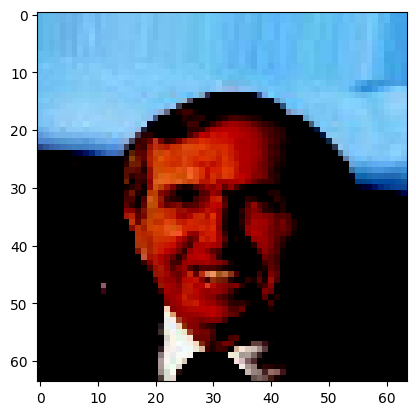

In [101]:
import matplotlib.pyplot as plt
plt.imshow((dataset[0][20]))
ic(dataset[0].min(), dataset[0].max())

In [ ]:

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_classes, n_epochs=100)

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  444.06150512695314
>1, 1/114, d1=0.682, d2=0.696 g=0.692
>1, 2/114, d1=0.488, d2=0.702 g=0.686
>1, 3/114, d1=0.311, d2=0.728 g=0.662
>1, 4/114, d1=0.155, d2=0.815 g=0.607
>1, 5/114, d1=0.083, d2=0.981 g=0.567
>1, 6/114, d1=0.064, d2=0.999 g=0.651
>1, 7/114, d1=0.081, d2=0.741 g=0.890
>1, 8/114, d1=0.107, d2=0.541 g=1.111
>1, 9/114, d1=0.065, d2=0.515 g=1.107
>1, 10/114, d1=0.041, d2=0.591 g=0.905
>1, 11/114, d1=0.043, d2=0.658 g=0.775
>1, 12/114, d1=0.090, d2=0.716 g=0.692
>1, 13/114, d1=0.013, d2=0.900 g=0.610
>1, 14/114, d1=0.010, d2=1.109 g=0.598
>1, 15/114, d1=0.059, d2=0.967 g=0.836
>1, 16/114, d1=0.233, d2=0.622 g=0.978
>1, 17/114, d1=0.229, d2=0.567 g=0.917
>1, 18/114, d1=0.047, d2=0.585 g=0.877
>1, 19/114, d1=0.020, d2=0.623 g=0.827
>1, 20/114, d1=0.007, d2=0.690 g=0.776
>1, 21/114, d1=0.043, d2=0.815 g=0.745
>1, 22/114, d1=0.013, d2=0.800 g=0.925
>1, 23/114, d1=0.046, d2=0.603 g=0.945
>1, 24/114, d1=0.453, d2=0.697 g=0.701
>1, 25/114, d1=0.002, d2=0.789 g=0.660
>1, 26/11

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  507.77098388671874
>2, 1/114, d1=0.256, d2=0.034 g=5.803
>2, 2/114, d1=0.195, d2=0.043 g=4.357
>2, 3/114, d1=0.120, d2=0.083 g=4.199
>2, 4/114, d1=0.118, d2=0.080 g=4.262
>2, 5/114, d1=0.102, d2=0.048 g=4.131
>2, 6/114, d1=0.116, d2=0.056 g=3.922
>2, 7/114, d1=0.108, d2=0.050 g=3.802
>2, 8/114, d1=0.064, d2=0.070 g=3.933
>2, 9/114, d1=0.101, d2=0.069 g=3.965
>2, 10/114, d1=0.177, d2=0.104 g=3.460
>2, 11/114, d1=0.092, d2=0.093 g=4.253
>2, 12/114, d1=0.194, d2=0.083 g=4.202
>2, 13/114, d1=0.116, d2=0.071 g=4.823
>2, 14/114, d1=0.066, d2=0.048 g=4.858
>2, 15/114, d1=0.255, d2=0.134 g=4.525
>2, 16/114, d1=0.120, d2=0.076 g=4.805
>2, 17/114, d1=0.170, d2=0.089 g=5.612
>2, 18/114, d1=0.094, d2=0.060 g=5.472
>2, 19/114, d1=0.356, d2=0.180 g=5.999
>2, 20/114, d1=0.226, d2=0.101 g=5.561
>2, 21/114, d1=0.222, d2=0.246 g=8.510
>2, 22/114, d1=1.468, d2=0.559 g=6.036
>2, 23/114, d1=0.735, d2=0.424 g=5.920
>2, 24/114, d1=1.156, d2=1.562 g=8.621
>2, 25/114, d1=2.290, d2=0.667 g=4.412
>2, 26/11

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  363.67982177734376
>12, 1/114, d1=0.701, d2=0.620 g=1.055
>12, 2/114, d1=0.589, d2=0.658 g=1.010
>12, 3/114, d1=0.646, d2=0.608 g=1.013
>12, 4/114, d1=0.614, d2=0.586 g=1.036
>12, 5/114, d1=0.605, d2=0.655 g=0.995
>12, 6/114, d1=0.656, d2=0.747 g=0.950
>12, 7/114, d1=0.728, d2=0.762 g=0.961
>12, 8/114, d1=0.720, d2=0.711 g=0.970
>12, 9/114, d1=0.705, d2=0.741 g=1.021
>12, 10/114, d1=0.754, d2=0.688 g=1.027
>12, 11/114, d1=0.714, d2=0.560 g=1.099
>12, 12/114, d1=0.751, d2=0.622 g=1.062
>12, 13/114, d1=0.650, d2=0.632 g=1.089
>12, 14/114, d1=0.652, d2=0.646 g=1.140
>12, 15/114, d1=0.660, d2=0.572 g=1.128
>12, 16/114, d1=0.670, d2=0.611 g=1.192
>12, 17/114, d1=0.686, d2=0.609 g=1.027
>12, 18/114, d1=0.650, d2=0.615 g=1.048
>12, 19/114, d1=0.615, d2=0.591 g=1.050
>12, 20/114, d1=0.700, d2=0.605 g=1.029
>12, 21/114, d1=0.698, d2=0.684 g=0.980
>12, 22/114, d1=0.666, d2=0.617 g=1.014
>12, 23/114, d1=0.706, d2=0.670 g=0.978
>12, 24/114, d1=0.639, d2=0.624 g=1.031
>12, 25/114, d1=0.738, d

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  303.9247619628906
>22, 1/114, d1=0.646, d2=0.617 g=1.028
>22, 2/114, d1=0.732, d2=0.653 g=0.982
>22, 3/114, d1=0.730, d2=0.610 g=1.092
>22, 4/114, d1=0.681, d2=0.627 g=0.975
>22, 5/114, d1=0.647, d2=0.723 g=0.996
>22, 6/114, d1=0.678, d2=0.587 g=1.124
>22, 7/114, d1=0.636, d2=0.556 g=1.121
>22, 8/114, d1=0.692, d2=0.661 g=1.003
>22, 9/114, d1=0.632, d2=0.640 g=1.079
>22, 10/114, d1=0.658, d2=0.605 g=1.100
>22, 11/114, d1=0.737, d2=0.686 g=1.088
>22, 12/114, d1=0.617, d2=0.628 g=1.214
>22, 13/114, d1=0.653, d2=0.537 g=1.231
>22, 14/114, d1=0.652, d2=0.546 g=1.011
>22, 15/114, d1=0.659, d2=0.756 g=1.041
>22, 16/114, d1=0.589, d2=0.714 g=1.016
>22, 17/114, d1=0.623, d2=0.617 g=1.063
>22, 18/114, d1=0.730, d2=0.668 g=1.118
>22, 19/114, d1=0.629, d2=0.596 g=1.158
>22, 20/114, d1=0.676, d2=0.544 g=1.046
>22, 21/114, d1=0.678, d2=0.610 g=0.983
>22, 22/114, d1=0.658, d2=0.604 g=0.976
>22, 23/114, d1=0.678, d2=0.643 g=0.991
>22, 24/114, d1=0.736, d2=0.664 g=0.939
>22, 25/114, d1=0.585, d2

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  284.61249084472655
>32, 1/114, d1=0.652, d2=0.663 g=0.881
>32, 2/114, d1=0.651, d2=0.706 g=0.840
>32, 3/114, d1=0.683, d2=0.727 g=0.875
>32, 4/114, d1=0.668, d2=0.678 g=0.863
>32, 5/114, d1=0.704, d2=0.675 g=0.887
>32, 6/114, d1=0.699, d2=0.659 g=0.948
>32, 7/114, d1=0.678, d2=0.634 g=0.975
>32, 8/114, d1=0.650, d2=0.572 g=0.946
>32, 9/114, d1=0.645, d2=0.629 g=0.928
>32, 10/114, d1=0.672, d2=0.595 g=0.927
>32, 11/114, d1=0.629, d2=0.638 g=0.958
>32, 12/114, d1=0.727, d2=0.623 g=0.933
>32, 13/114, d1=0.712, d2=0.570 g=0.978
>32, 14/114, d1=0.673, d2=0.590 g=0.961
>32, 15/114, d1=0.617, d2=0.873 g=0.977
>32, 16/114, d1=0.634, d2=1.036 g=0.901
>32, 17/114, d1=0.655, d2=0.664 g=0.970
>32, 18/114, d1=0.746, d2=0.566 g=0.974
>32, 19/114, d1=0.704, d2=0.611 g=0.898
>32, 20/114, d1=0.608, d2=0.702 g=0.874
>32, 21/114, d1=0.557, d2=0.799 g=0.811
>32, 22/114, d1=0.565, d2=0.727 g=0.777
>32, 23/114, d1=0.551, d2=0.745 g=0.818
>32, 24/114, d1=0.587, d2=0.678 g=0.874
>32, 25/114, d1=0.649, d

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  265.98295440673826
>42, 1/114, d1=0.679, d2=0.692 g=0.873
>42, 2/114, d1=0.682, d2=0.594 g=0.925
>42, 3/114, d1=0.699, d2=0.650 g=0.934
>42, 4/114, d1=0.703, d2=0.623 g=0.860
>42, 5/114, d1=0.654, d2=0.717 g=0.849
>42, 6/114, d1=0.658, d2=0.687 g=0.808
>42, 7/114, d1=0.658, d2=0.720 g=0.835
>42, 8/114, d1=0.690, d2=0.692 g=0.841
>42, 9/114, d1=0.652, d2=0.664 g=0.883
>42, 10/114, d1=0.665, d2=0.683 g=0.879
>42, 11/114, d1=0.717, d2=0.635 g=0.895
>42, 12/114, d1=0.696, d2=0.645 g=0.922
>42, 13/114, d1=0.687, d2=0.658 g=0.943
>42, 14/114, d1=0.674, d2=0.625 g=0.900
>42, 15/114, d1=0.699, d2=0.651 g=0.901
>42, 16/114, d1=0.639, d2=0.660 g=0.782
>42, 17/114, d1=0.721, d2=0.717 g=0.779
>42, 18/114, d1=0.663, d2=0.711 g=0.831
>42, 19/114, d1=0.716, d2=0.650 g=0.870
>42, 20/114, d1=0.689, d2=0.640 g=0.891
>42, 21/114, d1=0.695, d2=0.670 g=0.872
>42, 22/114, d1=0.650, d2=0.608 g=0.866
>42, 23/114, d1=0.681, d2=0.635 g=0.908
>42, 24/114, d1=0.588, d2=0.627 g=0.934
>42, 25/114, d1=0.675, d

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  244.68627014160157
>52, 1/114, d1=0.692, d2=0.733 g=0.766
>52, 2/114, d1=0.653, d2=0.748 g=0.764
>52, 3/114, d1=0.684, d2=0.711 g=0.812
>52, 4/114, d1=0.721, d2=0.711 g=0.819
>52, 5/114, d1=0.658, d2=0.657 g=0.841
>52, 6/114, d1=0.717, d2=0.647 g=0.835
>52, 7/114, d1=0.718, d2=0.640 g=0.822
>52, 8/114, d1=0.651, d2=0.642 g=0.820
>52, 9/114, d1=0.729, d2=0.677 g=0.812
>52, 10/114, d1=0.697, d2=0.648 g=0.835
>52, 11/114, d1=0.678, d2=0.690 g=0.860
>52, 12/114, d1=0.664, d2=0.658 g=0.862
>52, 13/114, d1=0.699, d2=0.665 g=0.853
>52, 14/114, d1=0.694, d2=0.650 g=0.818
>52, 15/114, d1=0.695, d2=0.620 g=0.823
>52, 16/114, d1=0.747, d2=0.662 g=0.798
>52, 17/114, d1=0.617, d2=0.669 g=0.790
>52, 18/114, d1=0.623, d2=0.677 g=0.791
>52, 19/114, d1=0.608, d2=0.681 g=0.787
>52, 20/114, d1=0.623, d2=0.714 g=0.790
>52, 21/114, d1=0.609, d2=0.729 g=0.799
>52, 22/114, d1=0.684, d2=0.853 g=0.890
>52, 23/114, d1=0.701, d2=0.599 g=0.994
>52, 24/114, d1=0.660, d2=0.631 g=0.900
>52, 25/114, d1=0.702, d

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  242.65505676269532
>62, 1/114, d1=0.679, d2=0.667 g=0.831
>62, 2/114, d1=0.672, d2=0.664 g=0.821
>62, 3/114, d1=0.716, d2=0.648 g=0.796
>62, 4/114, d1=0.648, d2=0.674 g=0.784
>62, 5/114, d1=0.633, d2=0.702 g=0.766
>62, 6/114, d1=0.654, d2=0.775 g=0.759
>62, 7/114, d1=0.671, d2=0.716 g=0.761
>62, 8/114, d1=0.671, d2=0.708 g=0.802
>62, 9/114, d1=0.653, d2=0.653 g=0.792
>62, 10/114, d1=0.688, d2=0.671 g=0.839
>62, 11/114, d1=0.705, d2=0.652 g=0.844
>62, 12/114, d1=0.709, d2=0.680 g=0.889
>62, 13/114, d1=0.766, d2=0.646 g=0.848
>62, 14/114, d1=0.718, d2=0.635 g=0.826
>62, 15/114, d1=0.706, d2=0.660 g=0.829
>62, 16/114, d1=0.752, d2=0.625 g=0.815
>62, 17/114, d1=0.704, d2=0.679 g=0.763
>62, 18/114, d1=0.632, d2=0.638 g=0.809
>62, 19/114, d1=0.672, d2=0.710 g=0.782
>62, 20/114, d1=0.672, d2=0.672 g=0.772
>62, 21/114, d1=0.649, d2=0.711 g=0.826
>62, 22/114, d1=0.635, d2=0.690 g=0.787
>62, 23/114, d1=0.683, d2=0.707 g=0.784
>62, 24/114, d1=0.751, d2=0.708 g=0.772
>62, 25/114, d1=0.649, d

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  236.8696517944336
>72, 1/114, d1=0.661, d2=0.648 g=0.822
>72, 2/114, d1=0.667, d2=0.701 g=0.799
>72, 3/114, d1=0.708, d2=0.696 g=0.776
>72, 4/114, d1=0.709, d2=0.690 g=0.788
>72, 5/114, d1=0.641, d2=0.671 g=0.769
>72, 6/114, d1=0.678, d2=0.699 g=0.786
>72, 7/114, d1=0.688, d2=0.663 g=0.784
>72, 8/114, d1=0.656, d2=0.694 g=0.766
>72, 9/114, d1=0.687, d2=0.661 g=0.790
>72, 10/114, d1=0.714, d2=0.645 g=0.811
>72, 11/114, d1=0.694, d2=0.663 g=0.793
>72, 12/114, d1=0.691, d2=0.655 g=0.803
>72, 13/114, d1=0.705, d2=0.740 g=0.817
>72, 14/114, d1=0.700, d2=0.687 g=0.775
>72, 15/114, d1=0.721, d2=0.731 g=0.799
>72, 16/114, d1=0.722, d2=0.675 g=0.832
>72, 17/114, d1=0.711, d2=0.637 g=0.807
>72, 18/114, d1=0.650, d2=0.646 g=0.828
>72, 19/114, d1=0.664, d2=0.696 g=0.782
>72, 20/114, d1=0.719, d2=0.686 g=0.791
>72, 21/114, d1=0.703, d2=0.691 g=0.799
>72, 22/114, d1=0.752, d2=0.644 g=0.784
>72, 23/114, d1=0.696, d2=0.680 g=0.816
>72, 24/114, d1=0.695, d2=0.667 g=0.817
>72, 25/114, d1=0.704, d2

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  246.64444885253906
>82, 1/114, d1=0.696, d2=0.666 g=0.761
>82, 2/114, d1=0.664, d2=0.662 g=0.770
>82, 3/114, d1=0.705, d2=0.661 g=0.762
>82, 4/114, d1=0.641, d2=0.678 g=0.787
>82, 5/114, d1=0.658, d2=0.682 g=0.787
>82, 6/114, d1=0.673, d2=0.678 g=0.814
>82, 7/114, d1=0.679, d2=0.694 g=0.753
>82, 8/114, d1=0.656, d2=0.667 g=0.767
>82, 9/114, d1=0.673, d2=0.671 g=0.760
>82, 10/114, d1=0.684, d2=0.694 g=0.743
>82, 11/114, d1=0.702, d2=0.686 g=0.759
>82, 12/114, d1=0.694, d2=0.724 g=0.768
>82, 13/114, d1=0.679, d2=0.681 g=0.768
>82, 14/114, d1=0.673, d2=0.687 g=0.790
>82, 15/114, d1=0.627, d2=0.660 g=0.796
>82, 16/114, d1=0.666, d2=0.709 g=0.753
>82, 17/114, d1=0.667, d2=0.696 g=0.768
>82, 18/114, d1=0.700, d2=0.719 g=0.850
>82, 19/114, d1=0.723, d2=0.701 g=0.783
>82, 20/114, d1=0.677, d2=0.769 g=0.752
>82, 21/114, d1=0.694, d2=0.696 g=0.824
>82, 22/114, d1=0.725, d2=0.661 g=0.864
>82, 23/114, d1=0.675, d2=0.681 g=0.761
>82, 24/114, d1=0.706, d2=0.670 g=0.773
>82, 25/114, d1=0.704, d

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  231.77540283203126
>92, 1/114, d1=0.704, d2=0.654 g=0.822
>92, 2/114, d1=0.711, d2=0.638 g=0.809
>92, 3/114, d1=0.695, d2=0.640 g=0.782
>92, 4/114, d1=0.735, d2=0.704 g=0.816
>92, 5/114, d1=0.689, d2=0.669 g=0.795
>92, 6/114, d1=0.699, d2=0.680 g=0.753
>92, 7/114, d1=0.693, d2=0.679 g=0.776
>92, 8/114, d1=0.677, d2=0.689 g=0.753
>92, 9/114, d1=0.673, d2=0.694 g=0.789
>92, 10/114, d1=0.709, d2=0.722 g=0.769
>92, 11/114, d1=0.712, d2=0.689 g=0.793
>92, 12/114, d1=0.731, d2=0.697 g=0.749
>92, 13/114, d1=0.674, d2=0.665 g=0.788
>92, 14/114, d1=0.681, d2=0.675 g=0.732
>92, 15/114, d1=0.692, d2=0.673 g=0.750
>92, 16/114, d1=0.669, d2=0.698 g=0.760
>92, 17/114, d1=0.707, d2=0.685 g=0.771
>92, 18/114, d1=0.723, d2=0.702 g=0.761
>92, 19/114, d1=0.675, d2=0.714 g=0.785
>92, 20/114, d1=0.683, d2=0.651 g=0.802
>92, 21/114, d1=0.666, d2=0.697 g=0.771
>92, 22/114, d1=0.699, d2=0.655 g=0.764
>92, 23/114, d1=0.685, d2=0.734 g=0.782
>92, 24/114, d1=0.692, d2=0.667 g=0.778
>92, 25/114, d1=0.662, d

ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)
ic| gen_image.shape: (10, 64, 64, 3)
    real_image.shape: (10, 64, 64, 3)


fid:  234.35448455810547


In [ ]:
if not new_model:
  train_256(g_model, g_model_256, d_model_256, gan_model_256, dataset_256, latent_dim, n_epochs=10)

ic| labels: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
                   2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
                   4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
                   6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
                   8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


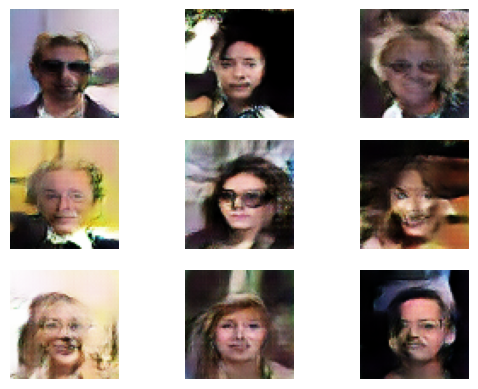

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=8):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

from matplotlib import pyplot
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow((examples[i, :, :, :]))
    pyplot.show()

# load model
dataset_birds = False
dataset_celebs = True
if dataset_birds:
  model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_generator_birds.keras')
  n_classes = 200
elif dataset_celebs:
  model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_generator_celebs.keras')
  n_classes = 8
elif dataset_birds_10_classes:
  model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes.keras')
  n_classes = 10
elif dataset_birds_10_classes_augm:
  model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes_augm.keras')
  n_classes = 10
# generate images
latent_points, labels = generate_latent_points(100, 100, n_classes)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
ic(labels)
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 3)

In [ ]:
model = load_model('/content/drive/MyDrive/ksy/models/cdcgan_generator_birds_10_classes_augm.keras')
# generate images
evaluate_fid(model)